## TOC:
* [Reading CVS files](#first-bullet)
* [Luminosity section](#second-bullet)
* [Trigger rate section](#third-bullet)
* [Model training section](#fourth-bullet)

In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage, misc
import datetime
from datetime import timedelta

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D, InputLayer

from scipy import ndimage, misc

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler

Using TensorFlow backend.


In [2]:
# Change presentation settings
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (15.0, 8.0)
matplotlib.rcParams["xtick.labelsize"] = 16
matplotlib.rcParams["ytick.labelsize"] = 16
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.titlesize"] = 16
matplotlib.rcParams["figure.titlesize"] = 16
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14

In [3]:
#runs = [302634, 302635, 305814, 306121, 306122, 306125, 306126]
runs = [306121, 306122, 306125, 306126]
#runs = [306121, 306122, 306126]
lumi_directory = data_directory = "./lumi"
rates_directory = "./rates"

# Reading cvs files <a class="anchor" id="first-bullet"></a>

Reading instantaneous luminosities from the cvs file produced with brilcalc and saving into a pandas dataframe:

In [41]:
df_rates = pd.DataFrame()
int_lumi2 = pd.DataFrame()
for run in runs:
    print("Loading %s" % run)
    path = "%s/lumi_%s.csv" % (lumi_directory, run)
    int_lumi2 = int_lumi2.append(pd.read_csv(path,
        names=["runfill", "ls", "time", "beamstatus", "energy", "delivered", "recorded", "avgpu", "source"]), 
        ignore_index=True);    
    path = "%s/dt_rates_%s.csv" % (rates_directory, run)
    df_rates = df_rates.append(pd.read_csv(path, 
        names=["run", "time", "board", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"]), 
        ignore_index=True);
print("Done.")

Loading 306121
Loading 306122
Loading 306125
Loading 306126
Done.


# Luminosity section <a class="anchor" id="second-bullet"></a>

Dropping useless rows inherited from the lumi CVS file:

In [42]:
int_lumi2["source"] = int_lumi2["source"].astype('str')
int_lumi2 = int_lumi2[int_lumi2["source"] != "nan"]
int_lumi2 = int_lumi2[int_lumi2["source"] != "source"]

Splitting run:fill field and the start and end lumi sections:

In [43]:
int_lumi2['run'], int_lumi2['fill'] = int_lumi2['runfill'].str.split(':', 1).str
int_lumi2['ls_start'], int_lumi2['ls_end'] = int_lumi2['ls'].str.split(':', 1).str

Converting run to integer and luminosities to float:

In [44]:
int_lumi2["run"] = int_lumi2["run"].astype('int')
int_lumi2["ls_start"] = int_lumi2["ls_start"].astype('int')
int_lumi2["ls_end"] = int_lumi2["ls_end"].astype('int')
int_lumi2["delivered"] = int_lumi2["delivered"].astype('float64')
int_lumi2["recorded"] = int_lumi2["recorded"].astype('float64') 

Converting time stamp to datetime:

In [45]:
def transform_time(data):
    from datetime import datetime
    time_str = data.time
    #print time_str
    datetime_object = datetime.strptime(time_str, "%m/%d/%y %H:%M:%S")
    #print datetime_object
    return datetime_object
int_lumi2["time"] = int_lumi2.apply(transform_time, axis=1);

Creating end time column from the start time:

In [46]:
int_lumi2["time_end"] = int_lumi2["time"]

Finding the runs and their start and end times:

In [47]:
boundaries = pd.DataFrame(columns=["run", "start", "end", "ls_start", "ls_end", "nLS"])
for i in runs:
    start = int_lumi2[int_lumi2["run"] == i]["time"]
    end = int_lumi2[int_lumi2["run"] == i]["time_end"]
    start_ls = int_lumi2[int_lumi2["run"] == i]["ls_start"]
    end_ls = int_lumi2[int_lumi2["run"] == i]["ls_end"]
    start =  start.reset_index(drop=True)
    end =  end.reset_index(drop=True)
    start_ls =  start_ls.reset_index(drop=True)
    end_ls =  end_ls.reset_index(drop=True)
    nLS = int(start_ls.iloc[-1]) - int(start_ls.iloc[0]) + 1
    print i, start.iloc[0], start.iloc[-1], start_ls.iloc[0], start_ls.iloc[-1], nLS
    boundaries = boundaries.append({"run": i, "start": start.iloc[0], "end": start.iloc[-1], 
                                   "ls_start": start_ls.iloc[0], "ls_end": start_ls.iloc[-1], "nLS": nLS}, 
                                   ignore_index = True)

306121 2017-11-03 13:10:09 2017-11-03 13:52:52 42 152 111
306122 2017-11-03 13:53:18 2017-11-03 14:46:08 1 137 137
306125 2017-11-03 14:46:12 2017-11-04 10:14:06 1 3007 3007
306126 2017-11-04 10:14:24 2017-11-04 13:28:39 1 501 501


Reindexing the dataframe after removing some lines:

In [48]:
int_lumi2.index = pd.RangeIndex(len(int_lumi2.index))

In [49]:
print len(int_lumi2.index)

3756


Filling end time column:

In [50]:
def addTimeOffSet(startdate):
    enddate = pd.to_datetime(startdate) + pd.DateOffset(seconds=23)
    return enddate

def shiftElement(df, boundaries):
    run0 = boundaries["run"].iloc[0]
    for index, rows in df.iterrows():
        run = rows["run"]
        nls = int(boundaries[boundaries["run"] == run]["nLS"])
        if(run > run0):
            nls = nls + index
        #print run, nls
        if((index < nls) & (index < len(int_lumi2.index)-1)):
            #print index, run, rows["time"], df["time"][index+1]
            df.loc[index, "time_end"] = df["time"][index+1]
        elif (index == len(int_lumi2.index)-1):
            #print index, run, rows["time"], addTimeOffSet(rows["time"])
            df.loc[index, "time_end"] = addTimeOffSet(rows["time"])
                    
shiftElement(int_lumi2, boundaries)

Plotting the instantaneous luminosities:

In [51]:
def plot_inst_lumi(x_val, y_val, z_val, title):
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Inst. Lumi. [E30 Hz/cm$^2$]")
    xfmt = mdates.DateFormatter('%y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(x_val, y_val, 'ro-')
    plt.plot(x_val, z_val, 'bo-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

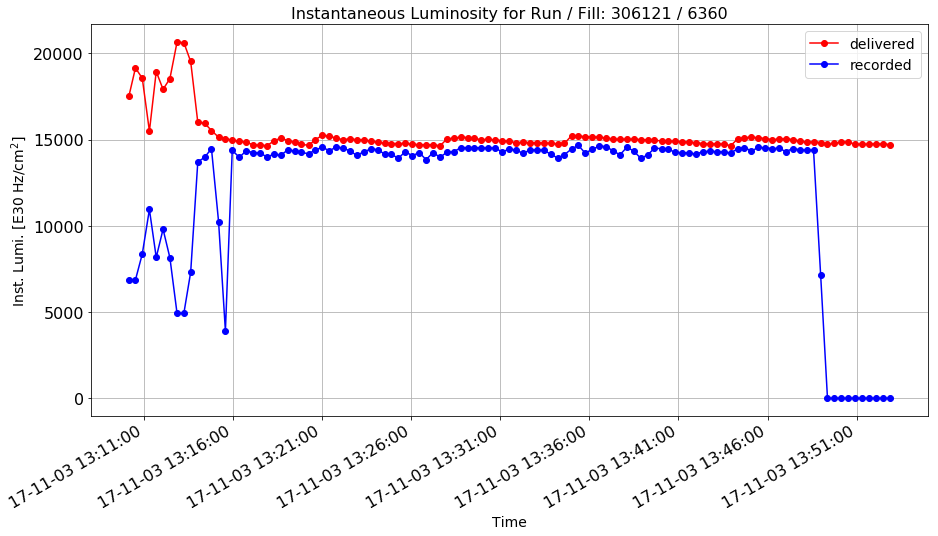

In [15]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 306121]["time"], 
               int_lumi2[int_lumi2["run"] == 306121]["delivered"], 
               int_lumi2[int_lumi2["run"] == 306121]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[0], int_lumi2["fill"].iloc[0])))

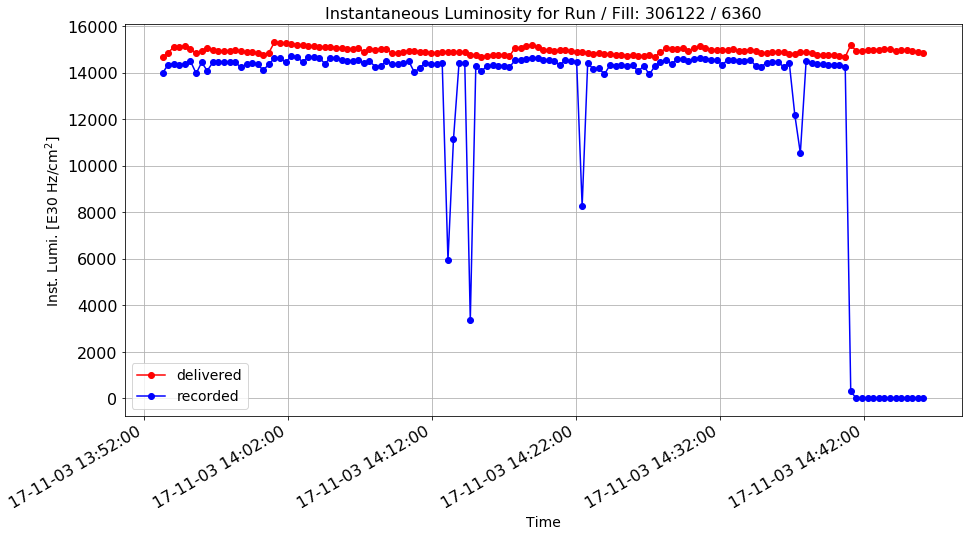

In [52]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 306122]["time"], 
               int_lumi2[int_lumi2["run"] == 306122]["delivered"], 
               int_lumi2[int_lumi2["run"] == 306122]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[1], int_lumi2["fill"].iloc[0])))

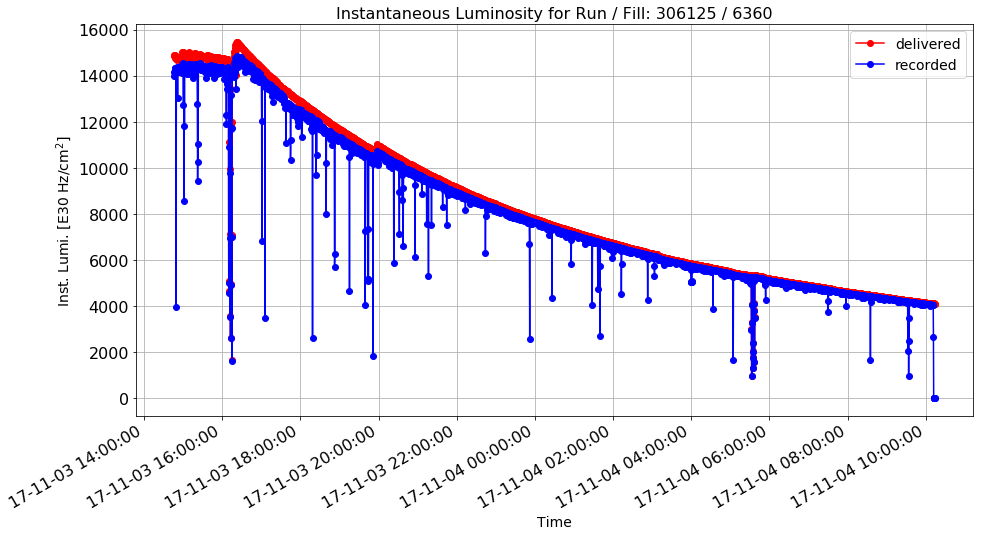

In [53]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 306125]["time"], 
               int_lumi2[int_lumi2["run"] == 306125]["delivered"], 
               int_lumi2[int_lumi2["run"] == 306125]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[2], int_lumi2["fill"].iloc[0])))

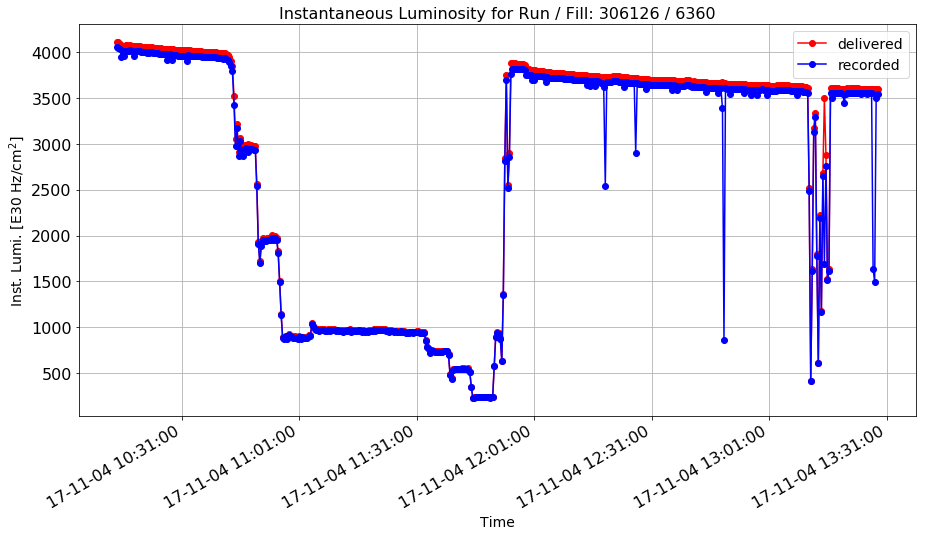

In [54]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 306126]["time"], 
               int_lumi2[int_lumi2["run"] == 306126]["delivered"], 
               int_lumi2[int_lumi2["run"] == 306126]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               (boundaries["run"].iloc[3], int_lumi2["fill"].iloc[0])))

In [55]:
int_lumi2.to_csv("int_lumi2.csv", sep='\t')

# Trigger rate section <a class="anchor" id="third-bullet"></a>

Converting columns to proper data types:

In [56]:
df_rates["time"] = pd.to_datetime(df_rates["time"])
df_rates["run"] = df_rates["run"].astype('int')
#print df_rates["time"]

Splitting, converting and adding new columns:

In [57]:
df_rates['wheel'], df_rates['sector'] = df_rates['board'].str.split('_', 1).str
df_rates["wheel"] = df_rates["wheel"].astype(str)
df_rates["sector"] = df_rates["sector"].astype(str)

In [58]:
df_rates["wheel"].replace(regex=True,inplace=True,to_replace=r'YB',value=r'')
df_rates["sector"].replace(regex=True,inplace=True,to_replace=r'S',value=r'')
df_rates["wheel"] = df_rates["wheel"].astype('int')
df_rates["sector"] = df_rates["sector"].astype('int')
df_rates["ls"] = -1
df_rates["lumi"] = -1.0
df_rates["score"] = -1
df_rates.to_csv("df_rates.csv", sep='\t')

Plotting the rate coming from one of the stations:

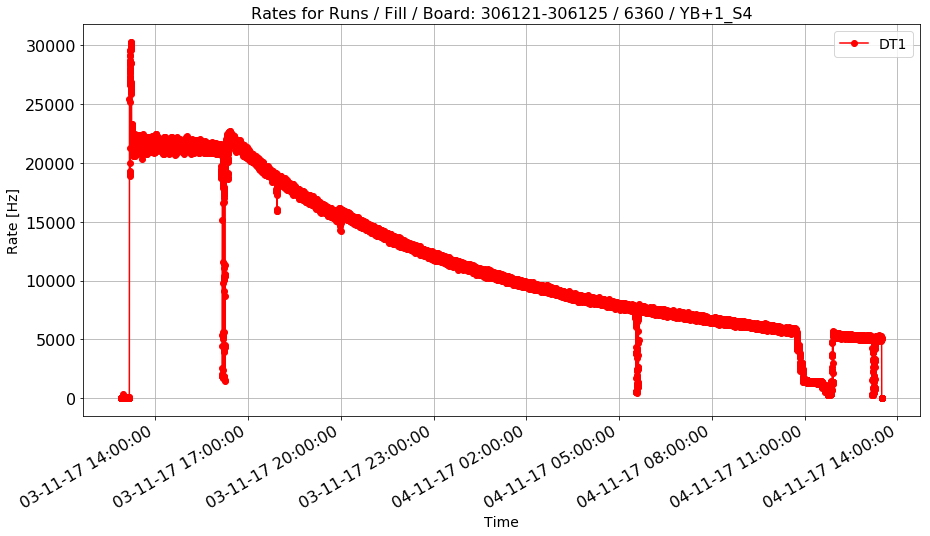

In [59]:
def plot_rate_vs_time(df, x_val, y_val, z_val, title):
    df_temp = df.copy()
    crit = df_temp["board"] == z_val
    df_temp = df_temp[crit]
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Rate [Hz]")
    ax.xaxis_date()
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], 'ro-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

plot_rate_vs_time(df_rates, "time", "DT1", "YB+1_S4", "Rates for Runs / Fill / Board: %s / %s / %s" % 
                  (str(boundaries["run"].iloc[0])+"-"+str(boundaries["run"].iloc[2]), 
                   int_lumi2["fill"].iloc[2], "YB+1_S4"))

Associating a LS and an instantaneous luminosity to each rate:

In [60]:
df_rates_backup = df_rates.copy()

In [61]:
#df_rates = df_rates_backup.copy()

Removing the measurements taken before and after the start and end time reported by the brilcalc output. All the 60 boards are measured at the same time. In order to speed-up the association, we take just one board, the first one. This reduces the dataframe and the time needed to go though it by a factor of 60.

In [62]:
time0 = boundaries["start"].iloc[0]
timeF = boundaries["end"].iloc[-1]
print time0, timeF
#print df_rates[(df_rates.time >= time0) & (df_rates.time <= timeF)]
df_rates = df_rates[(df_rates.time >= time0) & (df_rates.time <= timeF)]
rule = df_rates.duplicated(subset=["time"])
count = (rule == False).sum()
print "Duplicates:", rule.sum()
df_rates_noduplicates = df_rates[rule == False]
#print df_rates_noduplicates

2017-11-03 13:10:09 2017-11-04 13:28:39
Duplicates: 1593649


In [64]:
print len(df_rates_noduplicates)

27011


Assigning the LS and the inst. lumi. to the measurements for the selected board:

In [65]:
def assignLS(df1, df2, boundaries):
    temp = df1.copy()
    j = 1
    for index1, row1 in df1.iterrows():
        run1 = row1["run"]
        time1 = row1["time"]
        #print index1, run1, time1
        ti = time1 - 2*pd.DateOffset(seconds=23)
        tf = time1 + 2*pd.DateOffset(seconds=23)
        indexes2 = df2[(df2.run == run1) & (df2.time > ti) & (df2.time < tf)].index
        #print indexes2
        for i in indexes2:
            if((time1 >= df2["time"].loc[i]) & (time1 < df2["time_end"].loc[i])):
                #print time1, df2["time"].loc[i], df2["time_end"].loc[i]
                if(j%1000 == 0): 
                    print j
                j = j + 1
                ls = df2["ls_start"].loc[i]
                lumi = df2["delivered"].loc[i]
                #print index1, run1, time1, ls, lumi
                temp.loc[index1, "ls"] = ls
                temp.loc[index1, "lumi"] = lumi
                break
    return temp

temp = assignLS(df_rates_noduplicates, int_lumi2, boundaries)
df_rates_noduplicates = temp

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000


Removing the few cases not assigned and that are still at -1:

In [66]:
df_rates_noduplicates = df_rates_noduplicates[df_rates_noduplicates["ls"] > 0]
print len(df_rates_noduplicates)

26997


In [67]:
df_rates.to_csv("df_rates.csv", sep='\t')
df_rates_noduplicates.to_csv("df_rates_nodup.csv", sep='\t')

In [68]:
#df_rates = df_rates_backup.copy()

Assign the LS and the inst. lumi. to all the other 59 boards:

In [157]:
#IT TAKES TOOOOO LONG
def assignLS_ext(df1, df2):
    j = 0
    temp = df1.copy()
    for index in df2.index:
        #print index
        ls = df2["ls"].loc[index]
        lumi = df2["lumi"].loc[index]
        for i in range(index, index+60):
            j = j + 1
            if(j%1000 == 0):
                print j
            #print i, ls, lumi
            temp.loc[i, "ls"] = ls
            temp.loc[i, "lumi"] = lumi
    return temp
    
temp = assignLS_ext(df_rates, df_rates_noduplicates)
df_rates = temp

In [84]:
print df_rates[df_rates.ls <= 0]

Empty DataFrame
Columns: [run, time, board, RPC1, RPC2, RPC3, RPC4, DT1, DT2, DT3, DT4, DT5, wheel, sector, ls, lumi, score, errorDT1, errorDT2, errorDT3, errorDT4, errorDT5]
Index: []

[0 rows x 22 columns]


Removing measurements without LS assignment:

In [82]:
df_rates_backup = df_rates.copy()
df_rates = df_rates[df_rates.ls > 0]
#print df_rates["ls"]

In [83]:
#print df_rates[df_rates.ls <= 0]
df_rates.to_csv("df_rates.csv", sep='\t')

Averaging the rates associated to the same LS:

In [1028]:
df_boards = df_rates["board"]
df_boards = df_boards[df_boards.duplicated() == False]
print len(df_boards)
df_boards2 = pd.DataFrame(columns=["Board", "Measurements"])
for i in df_boards.index:
    #print i, df_boards.loc[i], len(df_rates[df_rates["board"] == df_boards.loc[i]])
    df_boards2.loc[i, "Board"] = df_boards.loc[i]
    df_boards2.loc[i, "Measurements"] = len(df_rates[df_rates["board"] == df_boards.loc[i]])

60


In [86]:
#print len(df_rates)
#print df_rates[(df_rates["ls"] == 42) & (df_rates["board"] == "YB0_S1")]["lumi"]

In [871]:
df_rates = df_rates_backup.copy()

In [1026]:
temp1 = df_rates.groupby(['run', 'lumi', 'ls', 'board', 'wheel', 'sector'])[["RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"]].mean().reset_index()
#print temp1.iloc[100]
temp2 = df_rates.groupby(['run', 'lumi', 'ls', 'board', 'wheel', 'sector'])[["RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"]].std().reset_index()
temp2 = temp2.rename(index=str, columns={"RPC1": "errRPC1", "RPC2": "errRPC2", "RPC3": "errRPC3", "RPC4": "errRPC4",
                                 "DT1": "errDT1", "DT2": "errDT2", "DT3": "errDT3", "DT4": "errDT4", "DT5": "errDT5"})
cols_to_use = temp2.columns.difference(temp1.columns)
temp2 = temp2[cols_to_use]
#print temp2.iloc[100]
temp1.reset_index(drop=True, inplace=True)
temp2.reset_index(drop=True, inplace=True)
df_rates = pd.concat([temp1, temp2], axis = 1)

In [1027]:
df_rates = df_rates.round(4) #TO-DO: Divide by sqrt{N}
#print df_rates

In [1029]:
print df_rates.isnull().values.any()
null_columns=df_rates.columns[df_rates.isnull().any()]
#print(df_rates[df_rates.isnull().any(axis=1)][null_columns].head())
df_rates = df_rates.fillna(0)
#print(df_rates[df_rates.isnull().any(axis=1)][null_columns].head())

False


In [956]:
df_rates_backup = df_rates.copy()
df_rates.to_csv("df_rates.csv", sep='\t')

In [957]:
#df_rates = df_rates_backup.copy()

In [958]:
print len(df_rates)

224100


Assigning the average rates previously calculated to the remaining rows:

In [959]:
#Check one case
#for index, row in df_rates.iterrows():
    #if row["board"] == "YB0_S1":
        #print "Index:", index,", Run:", row["run"],", Board: ",row["board"],", LS: ",row["ls"],", Rate: ",row["DT1"],", Error: ",row["errDT1"]

Plotting the result:

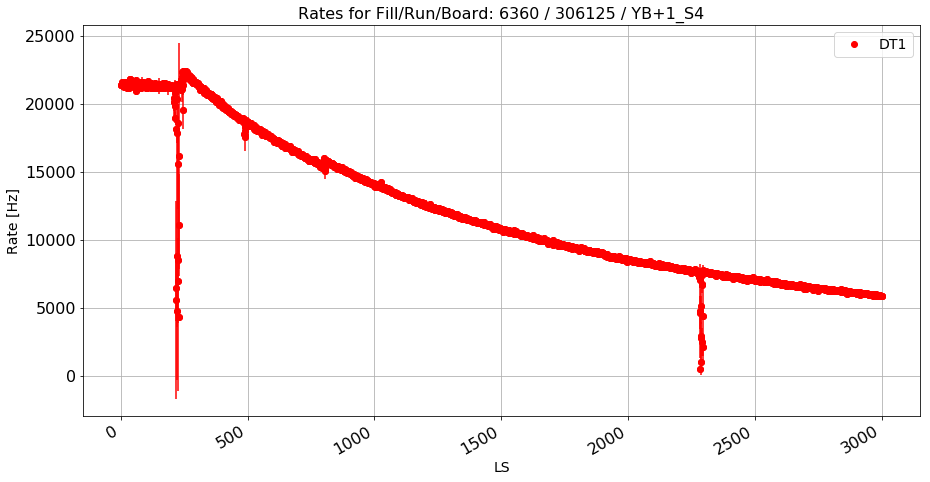

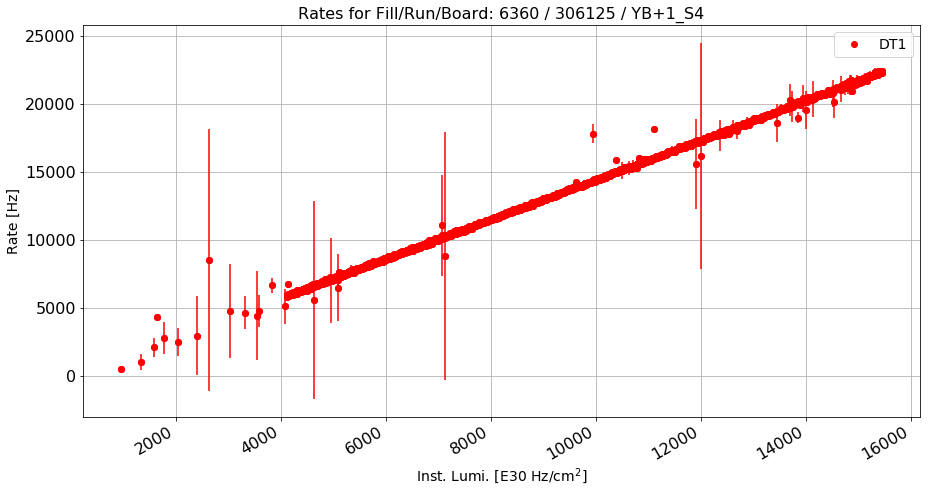

In [960]:
def plot_rate_vs_ls(df, run, x_val, y_val, z_val, x_err, y_err, title_x, title_y, title, opt):
    df_temp = df.copy()
    rule = ((df_temp["board"] == z_val) & (df_temp["run"] == run))
    df_temp = df_temp[rule]
    fig, ax = plt.subplots()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], opt)
    plt.legend(loc="best")
    plt.errorbar(df_temp[x_val], df_temp[y_val], xerr=x_err, yerr=df_temp[y_err], fmt='ro', ecolor='r')
    plt.title(title)
    plt.show();

title = "Rates for Fill/Run/Board: "+str(int_lumi2["fill"].iloc[0])+" / "+str(boundaries["run"].iloc[2])+" / YB+1_S4"
plot_rate_vs_ls(df_rates, 306125, "ls", "DT1", "YB+1_S4", 0, "errDT1", "LS", "Rate [Hz]", title, "ro")

plot_rate_vs_ls(df_rates, 306125, "lumi", "DT1", "YB+1_S4", 0, "errDT1", "Inst. Lumi. [E30 Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")

Too slow to use all the measurements. Sampling with a step of 10 LS:

In [1090]:
def assignGroup(data, div = 10):
    res = int(data/div)
    #print data, res
    return res

df_reduced = df_rates.copy()
df_reduced["group"] = df_reduced["ls"]
df_reduced["group"] = df_reduced["group"].apply(assignGroup)

In [1091]:
#print df_reduced
df_reduced["errLumi"] = -1.0
temp1 = df_reduced.groupby(['run', 'group', 'board', 'wheel', 'sector'])[["ls", "lumi", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5", "errRPC1", "errRPC2", "errRPC3", "errRPC4", "errDT1", "errDT2", "errDT3", "errDT4", "errDT5"]].mean().reset_index()
temp2 = df_reduced.groupby(['run', 'group', 'board', 'wheel', 'sector'])[["ls", "lumi", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5", "errRPC1", "errRPC2", "errRPC3", "errRPC4", "errDT1", "errDT2", "errDT3", "errDT4", "errDT5"]].std().reset_index()
temp2.rename(columns={'lumi': 'errLumi'}, inplace=True)
cols_to_use = temp2.columns.difference(temp1.columns)
#print cols_to_use
temp2 = temp2[cols_to_use]
#print temp2.iloc[100]
temp1.reset_index(drop=True, inplace=True)
temp2.reset_index(drop=True, inplace=True)
df_reduced = pd.concat([temp1, temp2], axis = 1)

Index([u'errLumi'], dtype='object')
errLumi    2072.51785
Name: 100, dtype: float64


In [1074]:
df_reduced = df_reduced.round(4)
df_reduced["ls"] = df_reduced["ls"].astype('int')
#print df_reduced

          run  group     board  wheel  sector   ls        lumi          RPC1  \
0      306121      4   YB+1_S1      1       1   45  18349.1749  2.108710e+05   
1      306121      4  YB+1_S10      1      10   45  18349.1749  2.858667e+05   
2      306121      4  YB+1_S11      1      11   45  18349.1749  2.536262e+05   
3      306121      4  YB+1_S12      1      12   45  18349.1749  2.490332e+05   
4      306121      4   YB+1_S2      1       2   45  18349.1749  2.882562e+05   
5      306121      4   YB+1_S3      1       3   45  18349.1749  2.305861e+05   
6      306121      4   YB+1_S4      1       4   45  18349.1749  2.630336e+05   
7      306121      4   YB+1_S5      1       5   45  18349.1749  2.925360e+05   
8      306121      4   YB+1_S6      1       6   45  18349.1749  2.211964e+06   
9      306121      4   YB+1_S7      1       7   45  18349.1749  2.595163e+05   
10     306121      4   YB+1_S8      1       8   45  18349.1749  2.515736e+05   
11     306121      4   YB+1_S9      1   

In [1092]:
print df_reduced.isnull().values.any()
null_columns=df_reduced.columns[df_reduced.isnull().any()]
#print(df_reduced[df_reduced.isnull().any(axis=1)][null_columns].head())
#print df_reduced.iloc[22500]
#print df_reduced[(df_reduced["group"] == 50) & (df_reduced["board"] == "YB+1_S1")]
df_reduced = df_reduced.fillna(0)
#print(df_reduced[df_reduced.isnull().any(axis=1)][null_columns].head())
print df_reduced.isnull().values.any()

True
False


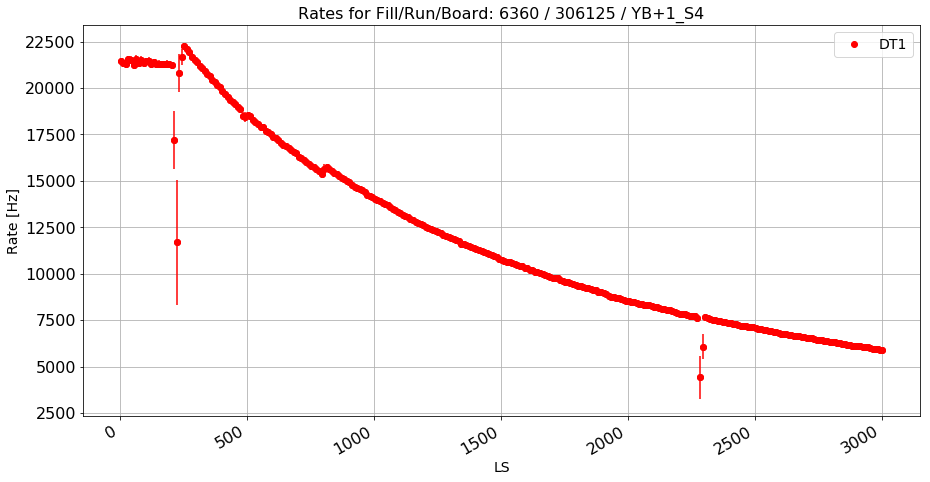

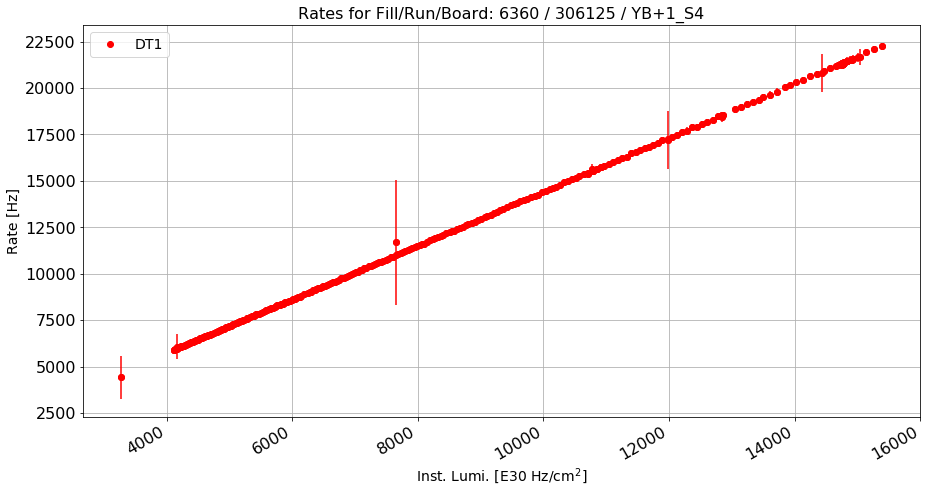

In [1093]:
title = "Rates for Fill/Run/Board: "+str(int_lumi2["fill"].iloc[0])+" / "+str(boundaries["run"].iloc[2])+" / YB+1_S4"
plot_rate_vs_ls(df_reduced, 306125, "ls", "DT1", "YB+1_S4", 0, "errDT1", "LS", "Rate [Hz]", title, "ro")

plot_rate_vs_ls(df_reduced, 306125, "lumi", "DT1", "YB+1_S4", 0, "errDT1", "Inst. Lumi. [E30 Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")

In [1094]:
print len(df_reduced)

22560


In [1097]:
df_rates_new = pd.DataFrame(columns=["wheel", "sector", "station", "content", "score"])
k = 0
for index, row in df_reduced.iterrows():
    for j in algos:
        k = k + 1
        if(k%5000 == 0):
            print k
        #print j
        system = -1
        station = -1
        if (j.find("RPC") != -1):
            system = 1
        else:
            system = 2
        #num = j.replace("RPC", "")
        num = j.replace("DT", "")
        station = int(num)
        array = [system, row["wheel"], row["sector"], station, row[j], row["err"+j], row["lumi"], row["errLumi"]]
        #print array
        df_rates_new = df_rates_new.append({"wheel":row["wheel"], "sector":row["sector"], 
                                            "station":station, "ls":row["ls"], "content":array, 
                                            "score":-1}, ignore_index=True)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000


# Model training section <a class="anchor" id="fourth-bullet"></a>

Creating train and test samples:

In [1098]:
normalies = df_rates_new.copy()
anomalies = df_rates_new.copy()

In [1099]:
print len(normalies), len(anomalies)

112800 112800


In [1100]:
rule = (normalies["wheel"] == -1) & (normalies["sector"] == 3) & (normalies["station"] == 3) 
print "Normal chimney:"
print normalies[rule]["content"].iloc[0]

rule = (normalies["wheel"] == 1) & (normalies["sector"] == 4) & (normalies["station"] == 3)
print "Anomalous chimney:"
print normalies[rule]["content"].iloc[0]

Normal chimney:
[2, -1, 3, 3, 4112.4306875, 146.03016250000002, 18349.174875, 1482.9735787624645]
Anomalous chimney:
[2, 1, 4, 3, 3138.2585999999997, 120.24486250000001, 18349.174875, 1482.9735787624645]


In [1101]:
def assignScore(df, score):
    temp = df.copy()
    rule = (temp["wheel"] == 1) & (temp["sector"] == 4) & (temp["station"] == 3)
    indexes = temp[rule].index
    #print indexes
    for i in indexes:
        temp.loc[i, "score"] = score
    return temp

temp = assignScore(anomalies, 1)
anomalies = temp

In [1102]:
rule = (anomalies["wheel"] == 1) & (anomalies["sector"] == 4) & (anomalies["station"] == 3)
#print anomalies[rule]["score"]

Forcing the rate to the one of the symmetric chimney chamber:

In [1103]:
def assignRate(df):
    rule1 = (df["wheel"] == 1) & (df["sector"] == 4) & (df["station"] == 3)# not good
    indexes1 = df[rule1].index
    #print indexes
    for i in indexes1:
        ls = df.loc[i]["ls"]
        rule2 = (df["wheel"] == -1) & (df["sector"] == 3) & (df["station"] == 3) & (df["ls"] == ls)
        indexes2 = (df[rule2].index) #it should contain one index
        #print i, index, time
        if(len(indexes2) > 0):
            j = indexes2[0]
            array = df.loc[j]["content"]
            rate = array[4] #good rate from the symmetric sector
            err = array[5] #uncertainty on the good rate from the symmetric sector
            content_orig = df.loc[i]["content"]
            content = list(content_orig)
            content[4] = rate
            content[5] = err
            df.at[i, "content"] = content
            #print i, j, time, rate, content_orig, content
        else:
            content_orig = df.loc[i]["content"]
            content = list(content_orig)
            content[4] = -1
            content[5] = -1
            df.at[i, "content"] = content
            #print i, j, time, rate, content_orig, content

assignRate(normalies)

Check that the change affects only normalies:

In [1104]:
rule = (normalies["wheel"] == -1) & (normalies["sector"] == 3) & (normalies["station"] == 3)
print "Normal chimney:"
print normalies[rule]["content"].iloc[0]

rule = (normalies["wheel"] == 1) & (normalies["sector"] == 4) & (normalies["station"] == 3)
print "Anomalous chimney:"
print normalies[rule]["content"].iloc[0]

Normal chimney:
[2, -1, 3, 3, 4112.4306875, 146.03016250000002, 18349.174875, 1482.9735787624645]
Anomalous chimney:
[2, 1, 4, 3, 4112.4306875, 146.03016250000002, 18349.174875, 1482.9735787624645]


In [1105]:
rule = (anomalies["wheel"] == -1) & (anomalies["sector"] == 3) & (anomalies["station"] == 3)
print "Normal chimney:"
print anomalies[rule]["content"].iloc[0]

rule = (anomalies["wheel"] == 1) & (anomalies["sector"] == 4) & (anomalies["station"] == 3)
print "Anomalous chimney:"
print anomalies[rule]["content"].iloc[0]

Normal chimney:
[2, -1, 3, 3, 4112.4306875, 146.03016250000002, 18349.174875, 1482.9735787624645]
Anomalous chimney:
[2, 1, 4, 3, 3138.2585999999997, 120.24486250000001, 18349.174875, 1482.9735787624645]


In [1106]:
#Scale the data
def scale_data(data):
    """Scales layer data using MaxAbsScaler"""
    # Need to reshape since scaler works per column
    data = data.reshape(-1, 1)
    scaler = MaxAbsScaler().fit(data)
    return scaler.transform(data).reshape(1, -1)

anomalies["content"] = anomalies["content"].apply(np.array)
anomalies["content_scaled"] = anomalies["content"].apply(scale_data)

normalies["content"] = normalies["content"].apply(np.array)
normalies["content_scaled"] = normalies["content"].apply(scale_data)

In [1107]:
#print anomalies["content_scaled"]
#print normalies["content_scaled"]

In [1108]:
# Set a random seed to reproduce the results
rng = np.random.RandomState(0)
anomalies = anomalies[anomalies.score == 1]
normalies = normalies[normalies.score == -1]
print("%s faults and %s good samples. In total: %s." %
      (len(anomalies), len(normalies), len(anomalies) + len(normalies)))

anomalies_train, anomalies_test = train_test_split(anomalies, test_size = 0.2, random_state=rng)
normalies_train, normalies_test = train_test_split(normalies, test_size = 0.2, random_state=rng)

neural_anomalies_train, neural_anomalies_val = train_test_split(anomalies_train, test_size = 0.2, random_state=rng)
neural_normalies_train, neural_normalies_val = train_test_split(normalies_train, test_size = 0.2, random_state=rng)

layers_train = pd.concat([anomalies_train, normalies_train])
layers_test = pd.concat([anomalies_test, normalies_test])

neural_train = pd.concat([neural_anomalies_train, neural_normalies_train])
neural_val = pd.concat([neural_anomalies_val, neural_normalies_val])

376 faults and 112800 good samples. In total: 113176.


In [1109]:
print("Number of anomalies in the train set: %s" % len(anomalies_train))
print("Number of normal in the train set: %s" % len(normalies_train))
print("Number of anomalies in the test set: %s" % len(anomalies_test))
print("Number of normal in the test set: %s" % len(normalies_test))

Number of anomalies in the train set: 300
Number of normal in the train set: 90240
Number of anomalies in the test set: 76
Number of normal in the test set: 22560


In [1110]:
#print anomalies

In [1111]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
K.set_session(sess)

In [1113]:
def score_to_array(score):
    if score == -1:
        return np.asarray([1, 0]) #Normaly
    return np.asarray([0, 1]) #Anomaly

def nn_generate_input():  
    return (np.array(np.concatenate(neural_train.content_scaled.values)).reshape(-1, 8),
            np.concatenate(neural_train["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(neural_val.content_scaled.values)).reshape(-1, 8),
            np.concatenate(neural_val["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(layers_test.content_scaled.values)).reshape(-1, 8))

(train_x, train_y, val_x, val_y, test_x) = nn_generate_input()

In [1114]:
def cae_generate_input():
    return np.array(np.concatenate(normalies_train.content_scaled.values)).reshape(-1, 8)

train_cae = cae_generate_input()

In [1115]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.utils import class_weight

cw = class_weight.compute_class_weight("balanced",
                                       np.unique(np.argmax(train_y, axis=1)),
                                       np.argmax(train_y, axis=1))
cw = {0: cw[0], 1: cw[1]}
print cw

{0: 0.50166223404255317, 1: 150.90000000000001}


Defining NN structure:

In [1294]:
def neural_network():
    model = Sequential()
    model.add(Reshape((8, 1), input_shape=(8,), name='input_ann'))
    model.add(Flatten(name="flatten_ann"))
    model.add(Dense(16, activation='relu', name="dense_ann"))
    model.add(Dense(16, activation='relu', name="dense_ann2"))
    model.add(Dense(16, activation='relu', name="dense_ann3"))
    model.add(Dense(16, activation='relu', name="dense_ann4"))
    model.add(Dense(2, activation='softmax', name='output_ann'))
    return model

def autoencoder():
    from keras.layers import Input, Dense
    from keras.models import Model
    input_ = Input(shape=(8,))
    encoded = Dense(8, activation='relu')(input_)
    encoded = Dense(7, activation='relu')(encoded)
    encoded = Dense(6, activation='relu')(encoded)
    encoded = Dense(5, activation='relu')(encoded)
    decoded = Dense(5, activation='relu')(encoded)
    decoded = Dense(6, activation='relu')(decoded)
    decoded = Dense(7, activation='relu')(decoded)
    decoded = Dense(8, activation='sigmoid')(decoded)

    autoencoder = Model(input_, decoded)
    return autoencoder

In [1295]:
ann = neural_network()
cae = autoencoder()
print("Neural Network Architecture:")
ann.summary()
print("Autoencoder Architecture:")
cae.summary()

Neural Network Architecture:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ann (Reshape)          (None, 8, 1)              0         
_________________________________________________________________
flatten_ann (Flatten)        (None, 8)                 0         
_________________________________________________________________
dense_ann (Dense)            (None, 16)                144       
_________________________________________________________________
dense_ann2 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_ann3 (Dense)           (None, 16)                272       
_________________________________________________________________
dense_ann4 (Dense)           (None, 16)                272       
_________________________________________________________________
output_ann (Dense)           (None, 2)         

Training the NN:

In [1122]:
# This may take some time...

def train_nn(model, x, y, batch_size, loss, name, validation_data=None, 
             validation_split=0.0, class_weight=None):

    model.compile(loss=loss, optimizer='Nadam')

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")
    
    checkpoint_callback = ModelCheckpoint(("./model_keras/%s.h5" % name),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    return model.fit(x, y,
                     batch_size=batch_size,
                     epochs=8192,
                     verbose=False,
                     class_weight=class_weight,
                     shuffle=True,
                     validation_split=validation_split,
                     validation_data=validation_data,
                     callbacks=[early_stopper, checkpoint_callback])

In [1123]:
history_ann = train_nn(ann,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "ann",
                       validation_data=(val_x, val_y),
                       class_weight=cw)

Epoch 02397: early stopping


In [1296]:
history_cae = train_nn(cae,
                       train_cae,
                       train_cae,
                       512,
                       keras.losses.mse,
                       "cae",
                       validation_split=0.2)

Epoch 00604: early stopping


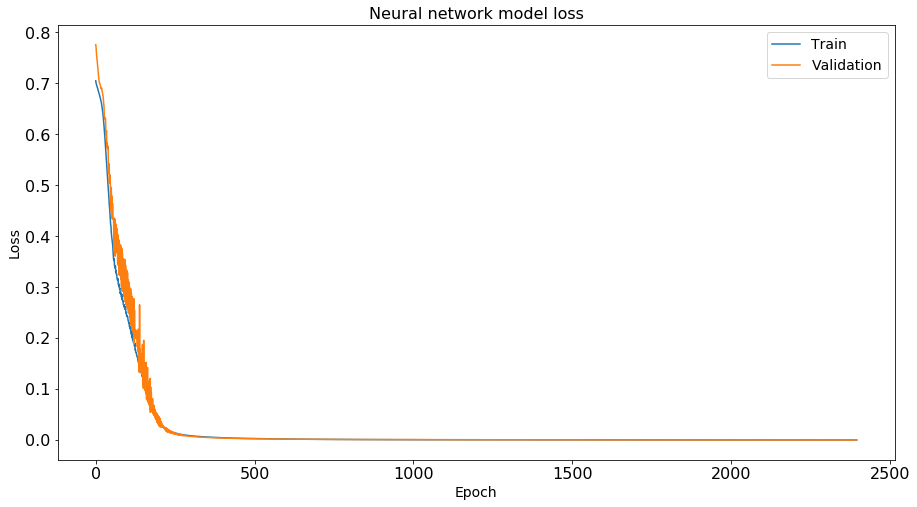

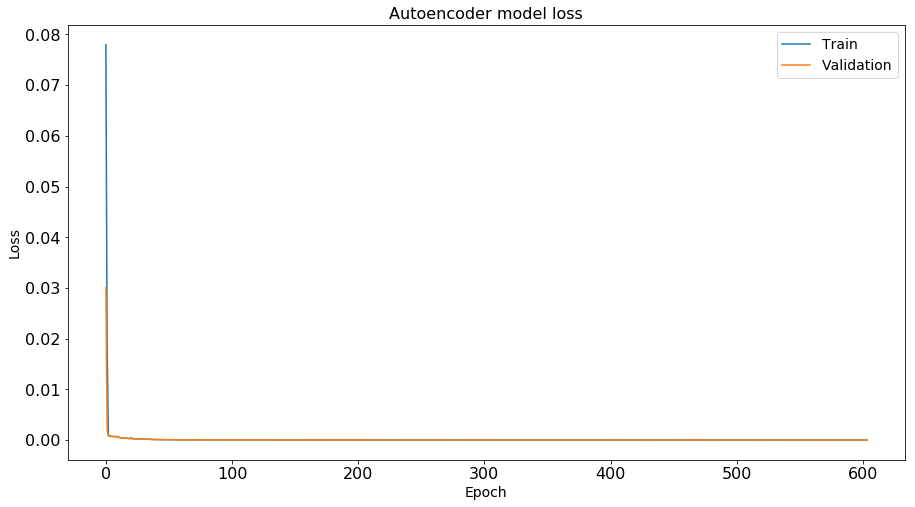

In [1297]:
def plot_training_loss(data, title):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data["loss"])
    plt.plot(data["val_loss"])
    plt.legend(["Train", "Validation"], loc="upper right")
    #plt.yscale("log")
    plt.show();

plot_training_loss(history_ann.history, "Neural network model loss")
plot_training_loss(history_cae.history, "Autoencoder model loss")

Making an inference using the model and the test sample:

In [1298]:
ann_model = load_model("./model_keras/ann.h5")
cae_model = load_model("./model_keras/cae.h5")

In [1299]:
layers_test["ann_score"] = ann_model.predict(np.array(test_x))[:, 1]
layers_test["cae_score"] = np.sum(abs(test_x - cae_model.predict(np.array(test_x))), axis=1)

In [1128]:
#print layers_test["ann_score"]
#print layers_test["score"]

In [1310]:
def benchmark(y_true, y_score, treshold):
    y_pred = 2*(y_score > treshold)-1
    y_true = 2*(y_true > treshold)-1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = round(float(tp)/(tp+fn), 4)
    specificity = round(float(tn)/(tn+fp), 4)

    print("Model accuracy: %s" % round(accuracy_score(y_true, y_pred), 4))
    print("Model sensitivity: %s" % sensitivity)
    print("Model specificity: %s" % specificity)

    return specificity, sensitivity
    
specificity_ann, sensitivity_ann = benchmark(layers_test["score"], layers_test["ann_score"], 0.5)
specificity_cae, sensitivity_cae = benchmark(layers_test["score"], layers_test["cae_score"], 0.02)

Model accuracy: 0.9999
Model sensitivity: 1.0
Model specificity: 0.9999
Model accuracy: 0.9219
Model sensitivity: 1.0
Model specificity: 0.9217


In [1131]:
def get_roc_curve(test_df, models, working_point=None):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()

    for legend_label, model_score in models:
        false_positive_rate, true_positive_rate, _ = roc_curve(test_df["score"],
                                                               test_df[model_score])

        plt.plot(false_positive_rate, true_positive_rate, linewidth=2,
                 label=('%s, AUC: %s' % (legend_label,
                                         round(auc(false_positive_rate, true_positive_rate), 4))))
    if working_point:
        plt.plot(1-working_point[0],
                 working_point[1],
                 'o',
                 label="ANN working point")
    plt.title("ROC")
    plt.legend(loc='best')
    plt.ylabel('Sensitivity (TPR)')
    plt.xlabel('Fall-out (TNR)')
    plt.show();

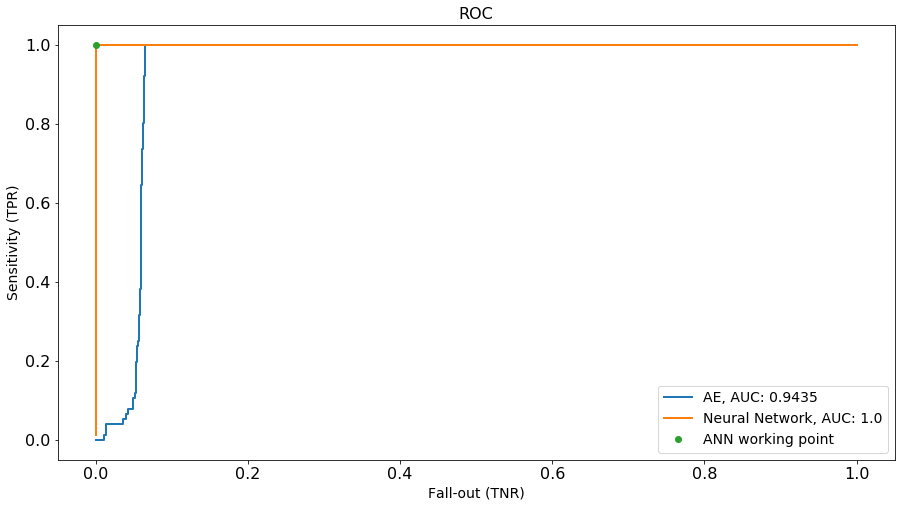

In [1311]:
get_roc_curve(layers_test, 
              [
               ("AE", "cae_score"),
               ("Neural Network", "ann_score"),
               ], (specificity_ann, sensitivity_ann))

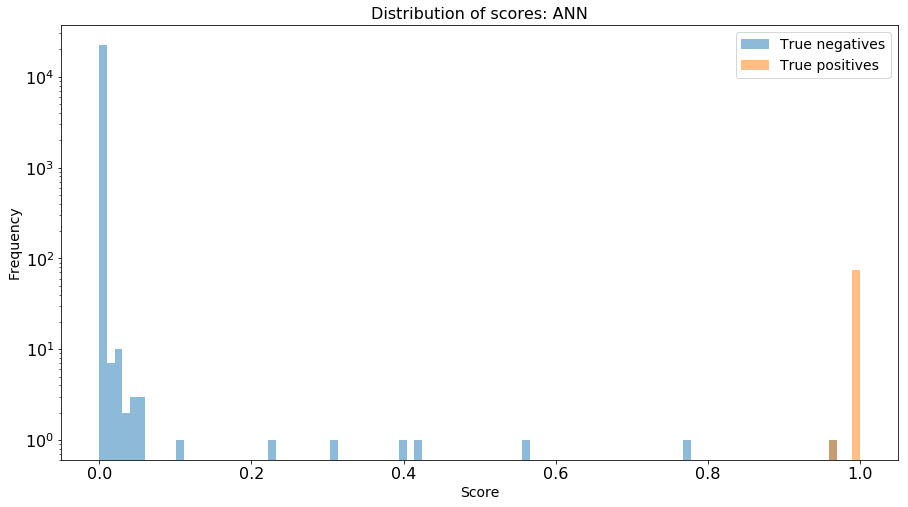

In [1292]:
# Distribution of scores:
fig, ax = plt.subplots()
ax.set_yscale('log')
bins = np.linspace(0, 1, 100)
plt.hist(layers_test[layers_test["score"] < 0]["ann_score"], bins=bins, alpha=0.5, label="True negatives")
plt.hist(layers_test[layers_test["score"] > 0]["ann_score"], bins=bins, alpha=0.5, label="True positives")
plt.title("Distribution of scores: ANN")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.show()

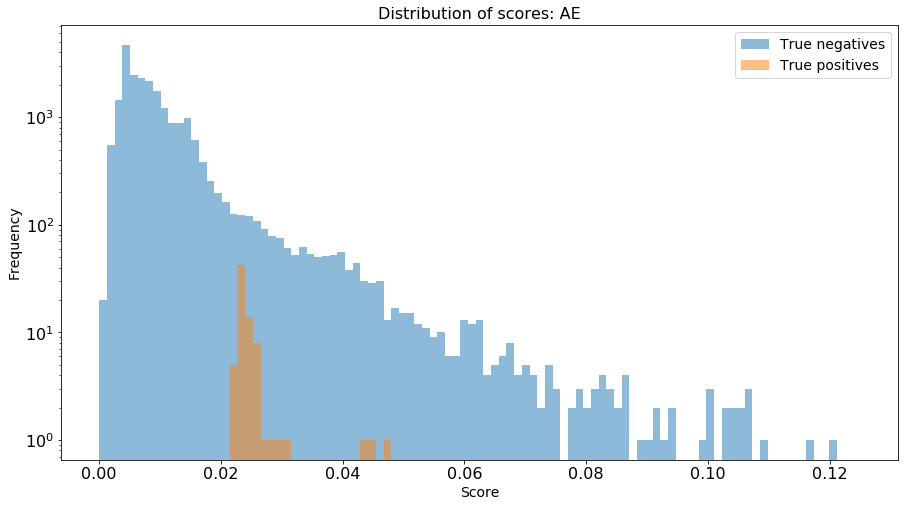

In [1306]:
fig, ax = plt.subplots()
ax.set_yscale('log')
bins = np.linspace(0, 0.125, 100)
plt.hist(layers_test[layers_test["score"] < 0]["cae_score"], bins=bins, alpha=0.5, label="True negatives")
plt.hist(layers_test[layers_test["score"] > 0]["cae_score"], bins=bins, alpha=0.5, label="True positives")
plt.title("Distribution of scores: AE")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.show()

In [1135]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[22557     3]
 [    0    76]]


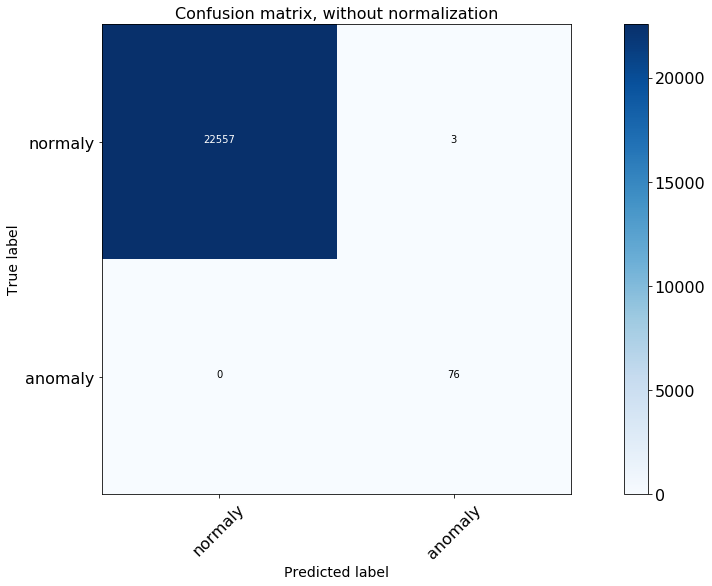

In [1312]:
threshold = 0.5
y_pred = 2*(layers_test["ann_score"] > threshold)-1
layers_test["score"] = 2*(layers_test["score"] > threshold)-1

cnf_matrix = confusion_matrix(layers_test["score"], y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=False,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[ 0.92167553  0.07832447]
 [ 0.          1.        ]]


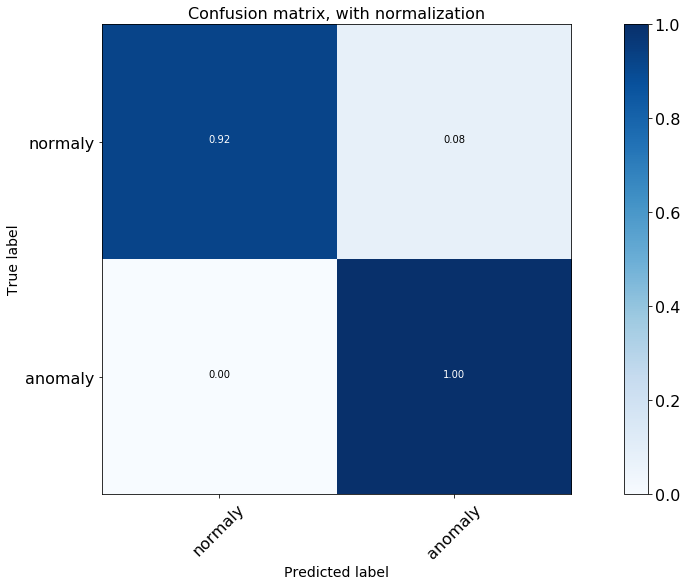

In [1304]:
threshold = 0.02
y_pred = 2*(layers_test["cae_score"] > threshold)-1
cnf_matrix = confusion_matrix(layers_test["score"], y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix, with normalization')

In [1238]:
print layers_test[(layers_test["score"] == -1) & (layers_test["ann_score"] > 0.5)]

       wheel sector station  \
101782     2      2       3   
3539      -2      9       5   
103882     2      2       3   

                                                  content  score     ls  \
101782  [2.0, 2.0, 2.0, 3.0, 205.49727, 12.72874, 976....     -1  144.5   
3539    [2.0, -2.0, 9.0, 5.0, 2827.40346667, 94.415811...     -1    5.0   
103882  [2.0, 2.0, 2.0, 3.0, 157.27469, 12.37779, 739....     -1  214.5   

                                           content_scaled  ann_score  \
101782  [[0.00204917864821, 0.00204917864821, 0.002049...   0.557230   
3539    [[0.00013365138105, -0.00013365138105, 0.00060...   0.769684   
103882  [[0.00270316297099, 0.00270316297099, 0.002703...   0.967389   

        cae_score  
101782   0.015286  
3539     0.014954  
103882   0.021679  


In [1313]:
print layers_test[(layers_test["score"] == -1) & (layers_test["cae_score"] > 0.02)]

       wheel sector station  \
103867     2     10       3   
105025     1      3       1   
101636    -2      9       2   
76100     -2      2       1   
48734     -1     11       5   
82139     -2      9       5   
99995      2      5       1   
111340     1      6       1   
77479      2     12       5   
111227    -2      7       3   
102573     0      4       4   
13856      1      9       2   
111143    -1      2       4   
11491      2      4       2   
105243     0      1       4   
693        2      4       4   
100520     1      2       1   
13655     -1      5       1   
278        0      5       4   
45839     -2      9       5   
87854      0     11       5   
102967     2     10       3   
395        2      5       1   
12134     -1     11       5   
104639    -2      9       5   
100570     2     11       1   
102223    -2      6       4   
62179      2     12       5   
108585     0      7       1   
105237    -2      9       3   
...      ...    ...     ...   
101735  